# Testing out different models

We need to now decide which model will be the most appropriate for this task. We have labeled data so we will focus on supervised learning models.

### Importing the packages

In [18]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns                                       
from sklearn.preprocessing import LabelEncoder
import pandas as pd

### Data preprocessing

In [60]:
num_vars = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

def input_transform(df_og, impute=True, no_nans = False):
    df = df_og.copy()
    
    if impute:
        ## We replace the missing values by the median of the numerical columns and the log transform
        # to normalize
        df[num_vars] = df[num_vars].apply(lambda col: col.fillna(col.median()), axis=0)
        df[num_vars[1:]] = df[num_vars[1:]].apply(lambda col: np.where(col > 0, np.log(col), col), 
                                                axis=0)
    
        # Everyone under 18 without a VIP status is assigned as non-VIP 
        df.VIP[(df.VIP.isnull()) & (df.Age<18)] = False

    ## We create interaction terms by separating PassengerId and uniting HomePlanet/Destination
    df[['GroupID', 'PartySize']] = df['PassengerId'].str.split('_', expand=True).astype(int)
    df['PartySize'] = df.groupby('GroupID')['PartySize'].transform('max')
    df[['Deck', 'RoomNbr','Side']] = df['Cabin'].str.split('/', expand=True)
    df['Road'] = df['HomePlanet'] + '_' + df['Destination']

    ## We drop all unique identifiers that do not bring any information
    df.drop(['HomePlanet','Destination','PassengerId', 'Name', 'Cabin', 'RoomNbr'], 
            axis=1, inplace=True)
    
    ## We label encode the categorical variables: Deck letter and the new Road variable
    le_Deck = LabelEncoder()
    le_Deck.fit(df.Deck)
    df['Deck'] = le_Deck.transform(df.Deck)
    le_Road = LabelEncoder()
    le_Road.fit(df.Road)
    df['Road'] = le_Road.transform(df.Road)

    ## All the binary categorical variables are transform into binary values
    df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0})
    if impute:
        df['VIP'] = df['VIP'].map({True: 1, False: 0}).fillna(0)
    else:
        df['VIP'] = df['VIP'].map({True: 1, False: 0})
    df['Side'] = df['Side'].map({'P': 1, 'S': 0})
    if no_nans:
        df.dropna(inplace=True)
    return(df.drop('Transported',axis=1), df.Transported)

In [61]:
df_og = pd.read_csv('train.csv')

## Logistic Regression

We want to predict a binary value (transported or not)

In [63]:
X,y = input_transform(df_og, no_nans=True)

/Users/johannawahn/opt/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6h/8sfx_lvj7qqcb000hqw9cckw0000gn/T/ipykernel_8311/3316866364.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.VIP[(df.VIP.isnull()) & (df.Age<18)] = False


In [65]:
from sklearn.linear_model import LogisticRegression

X = X.dropna()
clf = LogisticRegression(random_state=0).fit(X,y)
preds = clf.predict(X)

/Users/johannawahn/opt/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


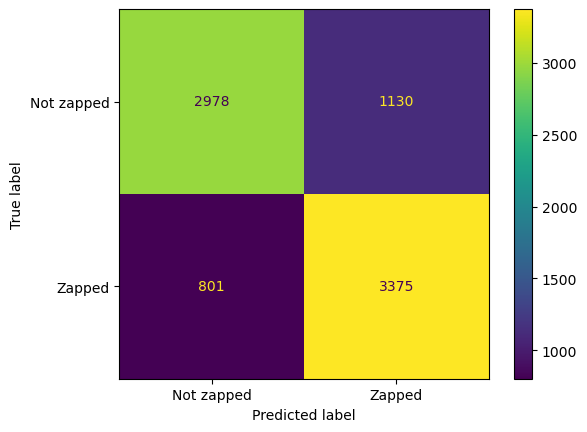

Accuracy: 0.7669000482858522
Precision: 0.7491675915649278


In [74]:
from sklearn.metrics import confusion_matrix as cm 
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score

cmatrix = cm(y,preds)
ConfusionMatrixDisplay(cmatrix, display_labels = ['Not zapped', 'Zapped']).plot()
plt.show()

print(f'Accuracy: {accuracy_score(y, preds)}')
print(f'Precision: {precision_score(y,preds)}')

Overall not that good of a result... but not all that terrible! Could have been due to all of the imputations we did.
Let's try another model!

## Decision tree